https://stackoverflow.com/questions/43214204/how-do-i-tell-if-a-column-in-a-pandas-dataframe-is-of-type-datetime-how-do-i-te    (datetime detection)

In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import datetime 

In [39]:
def seasonal_decompose_func(df, p=None, r=None):
    stl = STL(df, period=p, robust=r)
    result = stl.fit()
    seasonal, trend, resid = result.seasonal, result.trend, result.resid
    
    return seasonal, trend, resid

In [40]:
def ploting(df,seasonal,trend,resid):
    plt.figure(figsize=(20,12))

    plt.subplot(4,1,1)
    plt.plot(df)
    plt.title('Original Series', fontsize=16)

    plt.subplot(4,1,2)
    plt.plot(trend)
    plt.title('Trend', fontsize=16)

    plt.subplot(4,1,3)
    plt.plot(seasonal)
    plt.title('Seasonal', fontsize=16)

    plt.subplot(4,1,4)
    plt.plot(resid)
    plt.title('Residual', fontsize=16)

    plt.tight_layout() 

In [41]:
def iqr(resid, column, datafrm):
    resid_mu = resid.mean()
    resid_dev = resid.std()

    lower = resid_mu - 1.5*resid_dev
    upper = resid_mu + 1.5*resid_dev
    
    upper_index = np.where(resid > upper)
    lower_index = np.where(resid < lower)
    
    anomalies = column[(resid < lower) | (resid > upper)]

    #plt.figure(figsize=(10,4))
    #plt.plot(column.index, column)
  
    #plt.scatter(anomalies.index, anomalies, color='r', marker='D')
    
    colmn_name = column.columns
    colmn_name = str(colmn_name[0])
    
    datafrm[colmn_name] = "Normal"
    datafrm.iloc[[upper_index], datafrm.columns.get_loc(colmn_name)] = "Outlier"
    datafrm.iloc[[lower_index], datafrm.columns.get_loc(colmn_name)] = "Outlier"
    
    
    return anomalies, datafrm

https://stackoverflow.com/questions/68095810/statsmodels-tsa-stl-stl-unable-to-determine-period-from-endog

If your time series does not have a known frequency on the index (e.g., sdf.index.freq is None, then you need to set the period of the seasonality using the period. seasonal tells STL how many full seasons to use in the seasonal LOWESS but doesn't tell STL how many observations are needed for a full period.

In [42]:
def outlier_detect_STLandIQR(dataset):
    count = 0
    anomaly_data_frame = pd.DataFrame()
    unneccesary_columns = []
    datetime_column_available = dataset[[column for column in dataset.columns if is_datetime(dataset[column])]]
    if(datetime_column_available.empty == False):
        date_column_name = datetime_column_available.columns
        date_column_name = str(date_column_name[0])
        dataset = dataset.set_index(date_column_name)
        print("DateTime Column available")
        for column in dataset.columns:
            if ((type(dataset[column][0]) != np.float64) and (type(dataset[column][0]) != np.int64)):
                unneccesary_columns.append(column)
    
        for column in dataset.columns:
            if ((type(dataset[column][0]) == np.float64) or (type(dataset[column][0]) == np.int64)):
                df_column = pd.DataFrame(dataset[column])
                #df = df.resample('M').mean().ffill()      #If there is no known freq in the index that how many observation need to pick for a season (check the link in the above cell)
                                                  #otherwise we need to define the period in below line and comment/remove the resample line
                try:
                    print("Detected the period from datetime column")
                    seasonal, trend, resid = seasonal_decompose_func(df_column, r= True)
                except:
                    
                    if(count==0):
                        print("Despite having date column is this data frame, it's unable to detect the period. So, by default period =7")
                    seasonal, trend, resid = seasonal_decompose_func(df_column, p=7 ,r= True)
                if count == 0:
                    anomalies, dataframe = iqr (resid, df_column, dataset)
            
                    #plt.figure(figsize=(10,4))
                    #plt.plot(df.index, df)
                    #plt.ylabel(column)
                    #plt.scatter(anomalies.index, anomalies, color='r', marker='D')
            
             
                    anomaly_data_frame[column] = [int(anomalies.count())]
                    print(str(column) + " anomalies number is" + str(anomalies.shape))
                else:
                    anomalies, dataframe = iqr (resid, df_column, dataframe)
            
                    #plt.figure(figsize=(10,4))
                    #plt.plot(df.index, df)
                    #plt.ylabel(column)
                    #plt.scatter(anomalies.index, anomalies, color='r', marker='D')
            
            
                    anomaly_data_frame[column] = [int(anomalies.count())]
                    print(str(column) + " anomalies number is" + str(anomalies.shape))
                count+=1
    else: 
        print("DateTime Column Unvailable")
        for column in dataset.columns:
            if ((type(dataset[column][0]) != np.float64) and (type(dataset[column][0]) != np.int64)):
                unneccesary_columns.append(column)
    
        for column in dataset.columns:
            if ((type(dataset[column][0]) == np.float64) or (type(dataset[column][0]) == np.int64)):
                df_column = pd.DataFrame(dataset[column])
                #df = df.resample('M').mean().ffill()      #If there is no known freq in the index that how many observation need to pick for a season (check the link in the above cell)
                                                  #otherwise we need to define the period in below line and comment/remove the resample line
                try:
                    if(count==0):
                        print("by default period =7")
                                             
                    seasonal, trend, resid = seasonal_decompose_func(df_column, p=7, r= True)
                except:
                    print("Error occured")
                
                if count == 0:
                    anomalies, dataframe = iqr (resid,df_column, dataset)
            
                    #plt.figure(figsize=(10,4))
                    #plt.plot(df.index, df)
                    #plt.ylabel(column)
                    #plt.scatter(anomalies.index, anomalies, color='r', marker='D')
            
             
                    anomaly_data_frame[column] = [int(anomalies.count())]
                    print(str(column) + " anomalies number is" + str(anomalies.shape))
                else:
                    anomalies, dataframe = iqr (resid, df_column, dataframe)
            
                    #plt.figure(figsize=(10,4))
                    #plt.plot(df.index, df)
                    #plt.ylabel(column)
                    #plt.scatter(anomalies.index, anomalies, color='r', marker='D')
            
            
                    anomaly_data_frame[column] = [int(anomalies.count())]
                    print(str(column) + " anomalies number is" + str(anomalies.shape))
                count+=1
        
    for column in unneccesary_columns:
        dataframe = dataframe.drop([column], axis = 1)
    dataframe = dataframe.add_suffix('_outlier')       
    return anomaly_data_frame, dataframe 

In [43]:
def show_anomaly_overview(anomaly_count_each_column):
    fig = plt.figure(figsize = (20, 6))
 
    # creating the bar plot
    columns_are = list(anomaly_count_each_column.columns)
    values  = list(anomaly_count_each_column.iloc[0])

    plt.barh(columns_are, values, color ='maroon')
 
    plt.ylabel("Columns")
    plt.xlabel("No. of anomaly")
    plt.title("Anomaly overview")
    plt.show()

In [44]:
def show_anomaly_for_a_column(column, main_dataframe, anomaly_dataframe):
    column = pd.DataFrame(column)
    column_name = column.columns
    column_name = str(column_name[0])
    main_column = pd.DataFrame(main_dataframe[[column_name]])
    anomaly_dataframe = anomaly_dataframe.reset_index()
    datetime_column_available = main_dataframe[[column for column in main_dataframe.columns if is_datetime(main_dataframe[column])]]
    if(datetime_column_available.empty == False):
        date_column_name = datetime_column_available.columns
        date_column_name = str(date_column_name[0])
        df = pd.merge(pd.merge(main_dataframe[[column_name]], anomaly_dataframe[column_name+'_outlier'],left_index=True, right_index=True),datetime_column_available,left_index=True, right_index=True)
        df = df.set_index(date_column_name)
        #print(df.head())
        #plt.figure(figsize = (20, 6))
        #sns.scatterplot(data=df, x=df.index , y=str(column_name), hue =str(column_name + '_outlier') )
        #plt.show()
        
        plt.figure(figsize=(20,6))
        sns.scatterplot(data=df, x=df.index , y=str(column_name), hue=str(column_name + '_outlier'))
        plt.plot(df.index, df[column_name])
        plt.show()
    else:
        df = pd.merge(main_dataframe[[column_name]], anomaly_dataframe[column_name+'_outlier'], left_index=True, right_index=True)
        plt.figure(figsize=(20,6))
        sns.scatterplot(data=df, x=df.index , y=str(column_name), hue=str(column_name + '_outlier'))
        plt.plot(df.index, df[column_name])
        plt.show()
        
    
    
    

# Test with different dataset

# Category 1: Dataset with datetime but failed to detect period

In [45]:
dataset1 = pd.read_csv("comp_fail_train_data.csv", parse_dates=['datetime'])
#dataset['datetime'] = pd.to_datetime(dataset['datetime'])
#dataset['datetime'] = pd.to_datetime(dataset.datetime).dt.tz_localize(None)
#dataset['date'] = dataset['datetime'].dt.date
#dataset = dataset.set_index('datetime')
display(dataset1.head())
print(dataset1.info())
print(dataset1.describe())

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4,model,age,failure
0,2015-01-02 05:00:00+00:00,BP3P13,179.178056,492.030275,91.155905,38.162571,27.497743,11.183028,17.366019,3.862876,...,0,0,0,199.958333,4.958333,34.958333,124.958333,model1,15,none
1,2015-01-02 08:00:00+00:00,BP3P13,169.073051,451.528135,95.460869,42.752140,19.283389,75.098589,4.837571,3.597729,...,0,0,0,200.083333,5.083333,35.083333,125.083333,model1,15,none
2,2015-01-02 11:00:00+00:00,BP3P13,170.608473,476.470942,100.674812,36.086376,21.764942,60.931854,12.521208,4.204943,...,0,0,0,200.208333,5.208333,35.208333,125.208333,model1,15,none
3,2015-01-02 14:00:00+00:00,BP3P13,174.670838,475.862555,97.439909,36.744674,23.224006,23.873635,13.829958,1.797458,...,0,0,0,200.333333,5.333333,35.333333,125.333333,model1,15,none
4,2015-01-02 17:00:00+00:00,BP3P13,182.207294,454.472370,95.440034,41.682170,14.765826,42.989149,15.565441,3.872835,...,0,0,0,200.458333,5.458333,35.458333,125.458333,model1,15,none


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22621 entries, 0 to 22620
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   datetime             22621 non-null  datetime64[ns, UTC]
 1   machineID            22621 non-null  object             
 2   voltmean             22621 non-null  float64            
 3   rotatemean           22621 non-null  float64            
 4   pressuremean         22621 non-null  float64            
 5   vibrationmean        22621 non-null  float64            
 6   voltsd               22621 non-null  float64            
 7   rotatesd             22621 non-null  float64            
 8   pressuresd           22621 non-null  float64            
 9   vibrationsd          22621 non-null  float64            
 10  voltmean_24hrs       22621 non-null  float64            
 11  rotatemean_24hrs     22621 non-null  float64            
 12  pressuremean_24hrs

DateTime Column available
Detected the period from datetime column
Despite having date column is this data frame, it's unable to detect the period. So, by default period =7
voltmean anomalies number is(2169, 1)
Detected the period from datetime column
rotatemean anomalies number is(2178, 1)
Detected the period from datetime column
pressuremean anomalies number is(2157, 1)
Detected the period from datetime column
vibrationmean anomalies number is(2181, 1)
Detected the period from datetime column
voltsd anomalies number is(2126, 1)
Detected the period from datetime column
rotatesd anomalies number is(2157, 1)
Detected the period from datetime column
pressuresd anomalies number is(2155, 1)
Detected the period from datetime column
vibrationsd anomalies number is(2125, 1)
Detected the period from datetime column
voltmean_24hrs anomalies number is(2137, 1)
Detected the period from datetime column
rotatemean_24hrs anomalies number is(2029, 1)
Detected the period from datetime column
pressurem

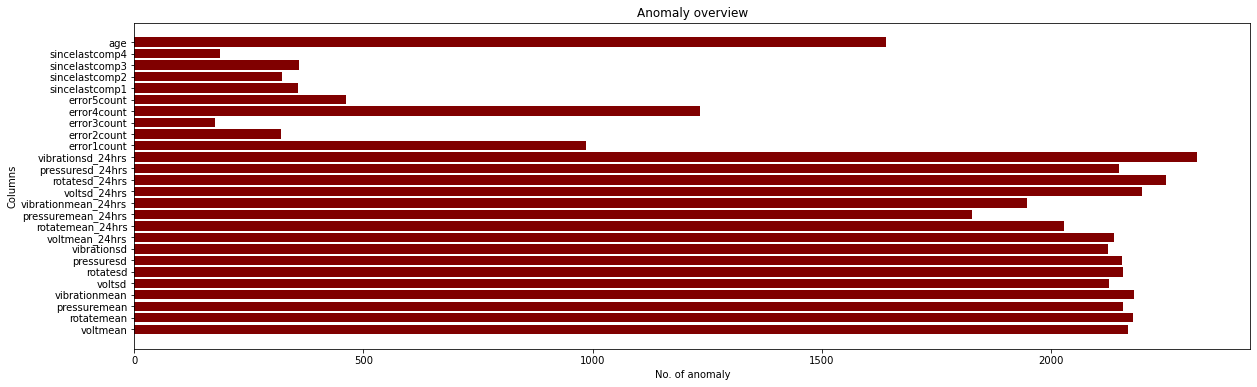

In [46]:
anomaly_count_each_column, dataset_anomaly = outlier_detect_STLandIQR(dataset1)
show_anomaly_overview(anomaly_count_each_column)

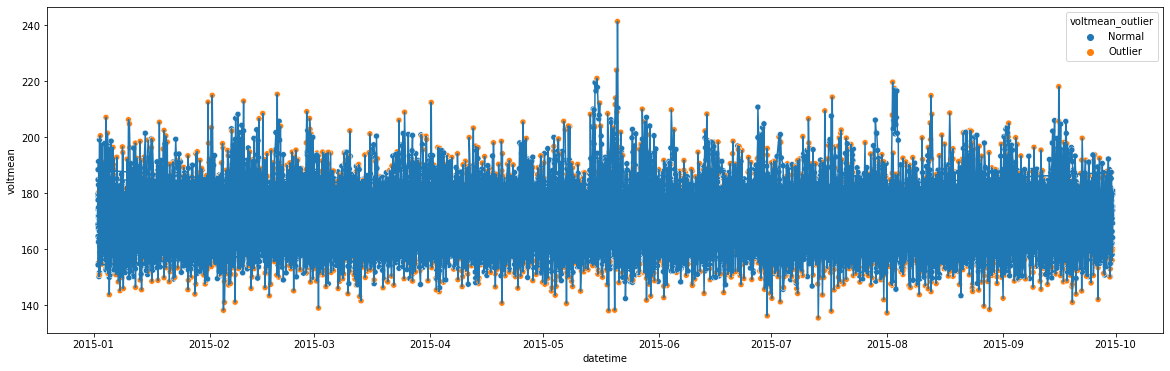

In [47]:
show_anomaly_for_a_column(dataset1['voltmean'], dataset1, dataset_anomaly)

In [48]:
dataset1['voltmean']

0        179.178056
1        169.073051
2        170.608473
3        174.670838
4        182.207294
            ...    
22616    169.224800
22617    176.889430
22618    181.264172
22619    175.499760
22620    159.589547
Name: voltmean, Length: 22621, dtype: float64

# Category 2: Dataset with datetime and able to detect period

In [49]:
dataset2 = pd.read_csv("lubridate.csv", parse_dates=['date'])
#dataset['datetime'] = pd.to_datetime(dataset['datetime'])
#dataset['datetime'] = pd.to_datetime(dataset.datetime).dt.tz_localize(None)
#dataset['date'] = dataset['datetime'].dt.date
#dataset = dataset.set_index('datetime')
display(dataset2.head())
print(dataset2.info())
print(dataset2.describe())

,date,count,package
0,2017-01-01,643,lubridate
1,2017-01-02,1350,lubridate
2,2017-01-03,2940,lubridate
3,2017-01-04,4269,lubridate
4,2017-01-05,3724,lubridate


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     425 non-null    datetime64[ns]
 1   count    425 non-null    int64         
 2   package  425 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 10.1+ KB
None
              count
count    425.000000
mean    4582.014118
std     2397.790866
min        0.000000
25%     3063.000000
50%     4112.000000
75%     6126.000000
max    12923.000000


DateTime Column available
Detected the period from datetime column
count anomalies number is(38, 1)


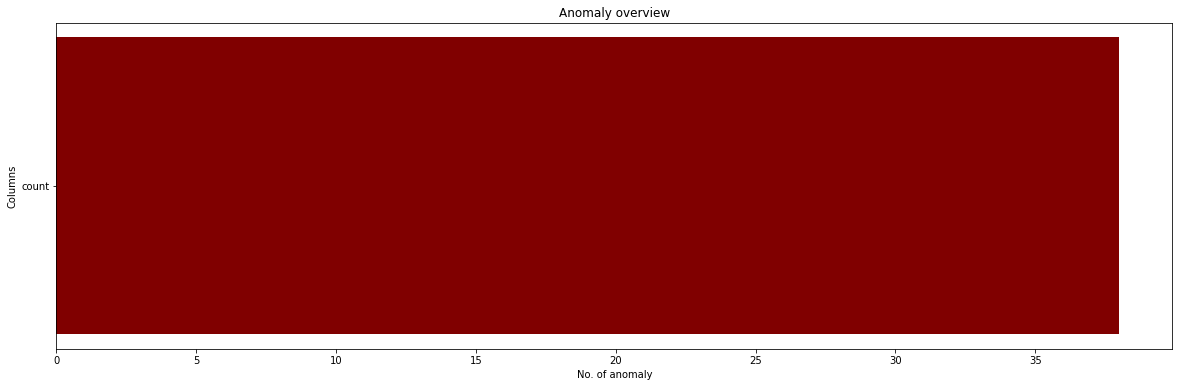

In [50]:
anomaly_count_each_column, dataset_anomaly = outlier_detect_STLandIQR(dataset2)
show_anomaly_overview(anomaly_count_each_column)

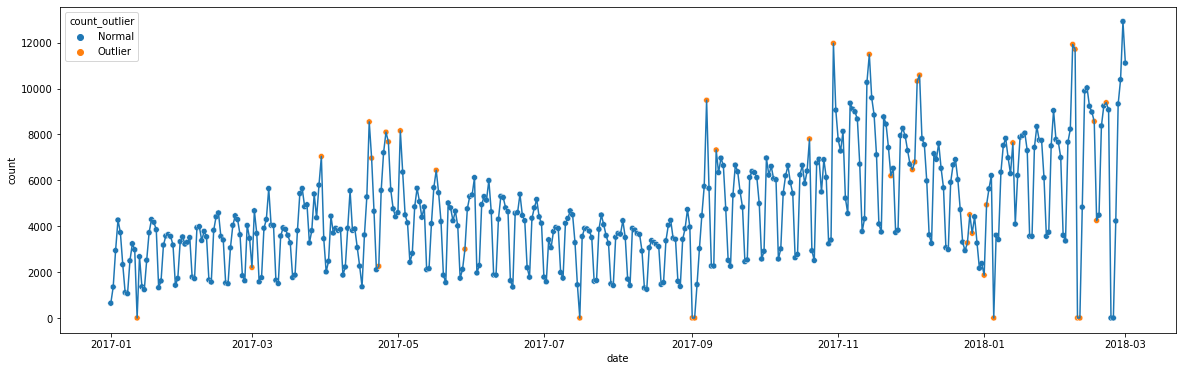

In [51]:
show_anomaly_for_a_column(dataset2['count'], dataset2, dataset_anomaly)

# Category 3: Dataset without datetime 

In [52]:
dataset3 = pd.read_csv("bmw.csv")
dataset3 = dataset3.drop('year', axis=1)
display(dataset3.head())
print(dataset3.info())
print(dataset3.describe())

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,14500,Automatic,39554,Diesel,160,50.4,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   price         10781 non-null  int64  
 2   transmission  10781 non-null  object 
 3   mileage       10781 non-null  int64  
 4   fuelType      10781 non-null  object 
 5   tax           10781 non-null  int64  
 6   mpg           10781 non-null  float64
 7   engineSize    10781 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 673.9+ KB
None
               price        mileage           tax           mpg    engineSize
count   10781.000000   10781.000000  10781.000000  10781.000000  10781.000000
mean    22733.408867   25496.986550    131.702068     56.399035      2.167767
std     11415.528189   25143.192559     61.510755     31.336958      0.552054
min      1200.000000       1.000000      0.000000      5.500000      0.000000
25%

DateTime Column Unvailable
by default period =7
price anomalies number is(1071, 1)
mileage anomalies number is(1387, 1)
tax anomalies number is(1709, 1)
mpg anomalies number is(271, 1)
engineSize anomalies number is(2084, 1)


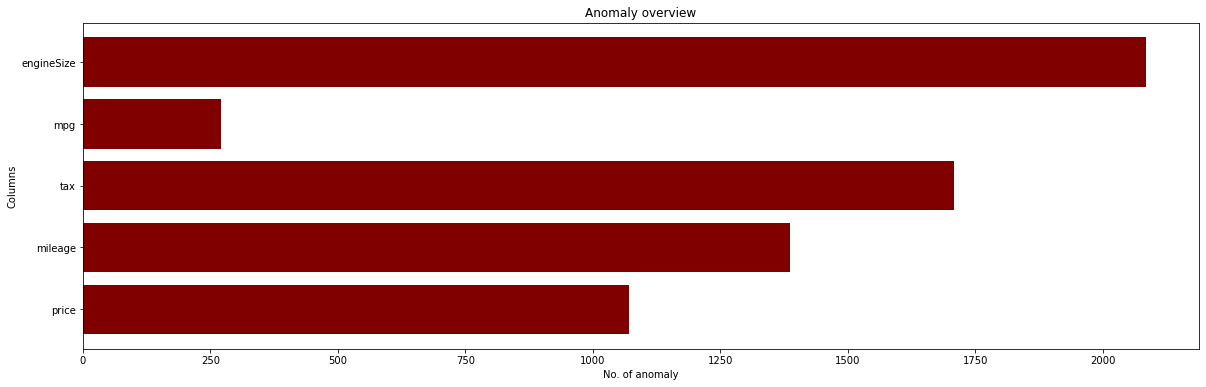

In [53]:
d = dataset3.copy()
anomaly_count_each_column, dataset_anomaly = outlier_detect_STLandIQR(d)
show_anomaly_overview(anomaly_count_each_column)

In [54]:
dataset3

,model,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,14500,Automatic,39554,Diesel,160,50.4,3.0
...,...,...,...,...,...,...,...,...
10776,X3,19000,Automatic,40818,Diesel,150,54.3,2.0
10777,5 Series,14600,Automatic,42947,Diesel,125,60.1,2.0
10778,3 Series,13100,Manual,25468,Petrol,200,42.8,2.0
10779,1 Series,9930,Automatic,45000,Diesel,30,64.2,2.0


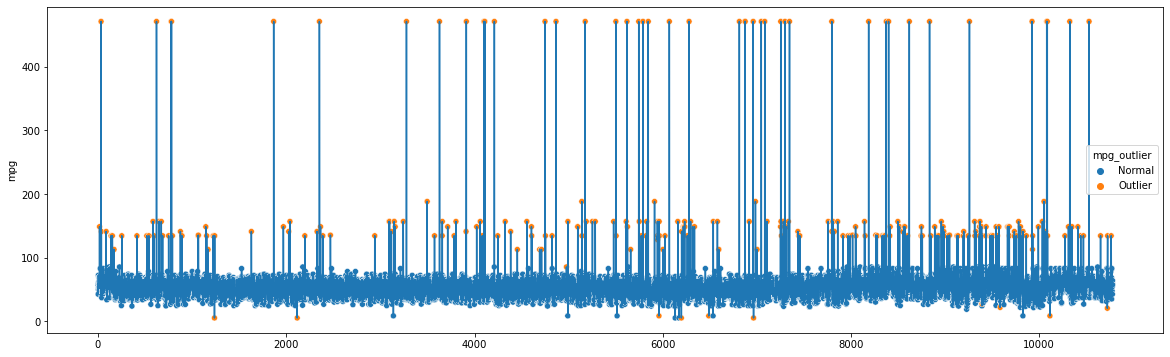

In [55]:
show_anomaly_for_a_column(dataset3['mpg'], dataset3, dataset_anomaly)

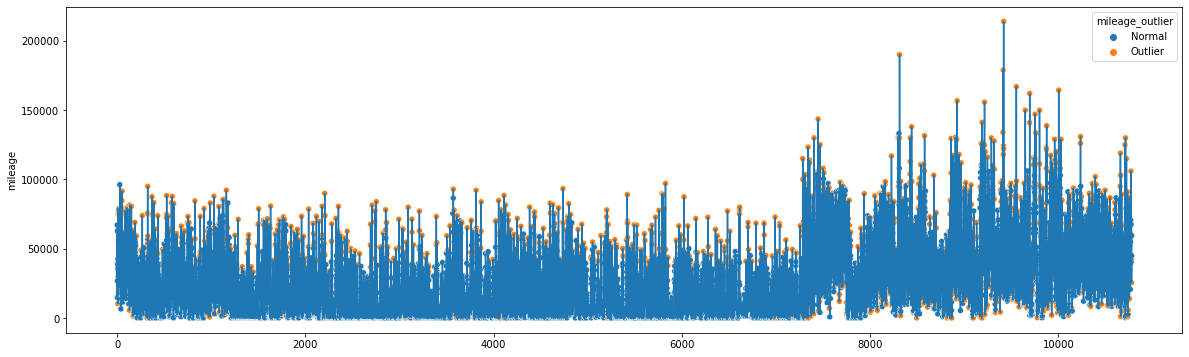

In [56]:
show_anomaly_for_a_column(dataset3['mileage'], dataset3, dataset_anomaly)

In [57]:
# count = 0
# anomaly_data_frame = pd.DataFrame()
# unneccesary_columns = []

# for column in dataset.columns:
#     if ((type(dataset[column][0]) != np.float64) and (type(dataset[column][0]) != np.int64)):
#         unneccesary_columns.append(column)

# for column in dataset.columns:
#      if ((type(dataset[column][0]) == np.float64) or (type(dataset[column][0]) == np.int64)):
#         df = pd.DataFrame(dataset[column])
#         #df = df.resample('M').mean().ffill()      #If there is no known freq in the index that how many observation need to pick for a season (check the link in the above cell)
#                                                   #otherwise we need to define the period in below line and comment/remove the resample line
#         seasonal, trend, resid = seasonal_decompose_func(df ,p=12 ,r= True)
#         if count == 0:
#             anomalies, dataset = iqr (resid,df, dataset)
            
#             plt.figure(figsize=(10,4))
#             plt.plot(df.index, df)
#             plt.ylabel(column)
#             plt.scatter(anomalies.index, anomalies, color='r', marker='D')
            
             
#             anomaly_data_frame[column] = [int(anomalies.count())]
#             print(str(column) + " anomalies number is" + str(anomalies.shape))
#         else:
#             anomalies, dataset = iqr (resid, df, dataset)
            
#             plt.figure(figsize=(10,4))
#             plt.plot(df.index, df)
#             plt.ylabel(column)
#             plt.scatter(anomalies.index, anomalies, color='r', marker='D')
            
            
#             anomaly_data_frame[column] = [int(anomalies.count())]
#             print(str(column) + " anomalies number is" + str(anomalies.shape))
#         count+=1
        